In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# AI Explanations: Deploying an image model

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-platform-samples/blob/master/notebooks/samples/explanations/tf2/ai-explanations-image.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-platform-samples/tree/master/notebooks/samples/explanations/tf2/ai-explanations-image.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## Overview

This tutorial shows how to train a Keras classification model on image data and deploy it to the AI Platform Explanations service to get feature attributions on your deployed model.

If you've already got a trained model and want to deploy it to AI Explanations, skip to the **Export the model as a TF 2 SavedModel** section.

### Dataset

The dataset used for this tutorial is the [flowers dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview).

### Objective

The goal of this tutorial is to train a model on a simple image dataset (flower classification) to understand how you can use AI Explanations with image models. For image models, AI Explanations returns an image with the pixels highlighted that contributed to your model's prediction the most.

This tutorial focuses more on deploying the model to AI Platform with Explanations than on the design of the model itself. 

### Costs

This tutorial uses billable components of Google Cloud Platform (GCP):

* AI Platform for:
  * Prediction
  * Explanation: AI Explanations comes at no extra charge to prediction prices. However, explanation requests take longer to process than normal predictions, so heavy usage of Explanations along with auto-scaling may result in more nodes being started and thus more charges
* Cloud Storage for:
  * Storing model files for deploying to Cloud AI Platform

Learn about [AI Platform
pricing](https://cloud.google.com/ml-engine/docs/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

You will need to install the latest version of the AI Platform Explanability SDK.

In [1]:
! pip install explainable-ai-sdk -U --user

     |████████████████████████████████| 100 kB 3.4 MB/s ta 0:00:011
     |████████████████████████████████| 26.1 MB 23.8 MB/s eta 0:00:01
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow-transform 0.22.0 requires tensorflow!=2.0.*,<2.3,>=1.15, but you'll have tensorflow 2.3.0 which is incompatible.
tensorflow-model-analysis 0.22.2 requires pyarrow<0.17,>=0.16, but you'll have pyarrow 1.0.1 which is incompatible.
tensorflow-data-validation 0.22.2 requires joblib<0.15,>=0.12, but you'll have joblib 0.16.0 which is incompatible.
tensorflow-data-validation 0.22.2 requires pyarrow<0.17,>=0.16, but you'll have pyarrow 1.0.1 which is incompatible.
pandas-profiling 2.8.0 requires visions[type_image_path]==0.4.4, but you'll have visions 0.5.0

### Restart the Kernel

Once you've installed the AI Platform Explanability SDK, you need to restart the notebook kernel so it can find the packages.

In [2]:
# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True) 

{'status': 'ok', 'restart': True}

## Before you begin

**Make sure you're running this notebook in a GPU runtime if you have that option. In Colab, select Runtime --> Change runtime type**


This tutorial assumes you are running the notebook either in **Colab** or **Cloud AI Platform Notebooks**.

### Set up your GCP project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a GCP project.](https://console.cloud.google.com/cloud-resource-manager)

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform Training & Prediction and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

4. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Project ID

**If you don't know your project ID.**

You might able to get your project ID using `gcloud` command, by executing the second code cell below.

In [1]:
PROJECT_ID = "[your-project-id]" #@param {type:"string"}

In [2]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

Project ID: andy-1234-221921


In [3]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Cloud
AI Platform services are
available](https://cloud.google.com/ml-engine/docs/tensorflow/regions). You can
not use a Multi-Regional Storage bucket for training with AI Platform.

In [4]:
REGION = 'us-central1' #@param {type: "string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append onto the name of resources which will be created in this tutorial.

In [5]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your GCP account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

In [6]:
import sys
import os

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your Google Cloud account. This provides access
# to your Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# If on AI Platform, then don't execute this code
if not os.path.exists('/opt/deeplearning/metadata/env_version'):
    if 'google.colab' in sys.modules:
        from google.colab import auth as google_auth
        google_auth.authenticate_user()

    # If you are running this tutorial in a notebook locally, replace the string
    # below with the path to your service account key and run this cell to
    # authenticate your Google Cloud account.
    else:
        %env GOOGLE_APPLICATION_CREDENTIALS your_path_to_credentials.json

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. AI Platform runs
the code from this package. In this tutorial, AI Platform also saves the
trained model that results from your job in the same bucket. You can then
create an AI Platform model version based on this output in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets. 

In [7]:
BUCKET_NAME = "[your-bucket-name]" #@param {type:"string"}

In [8]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "_xai_flowers_" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [9]:
! gsutil mb -l $REGION gs://$BUCKET_NAME

Creating gs://andy-1234-221921_xai_flowers_20200914211841/...


### Import libraries

Import the libraries for this tutorial.

In [10]:
import io
import random
import numpy as np
import PIL
import tensorflow as tf

from matplotlib import pyplot as plt
from base64 import b64encode

# should be >= 2.1
print("Tensorflow version " + tf.__version__)
if tf.__version__ < "2.1":
    raise Exception("TF 2.1 or greater is required")

AUTO = tf.data.experimental.AUTOTUNE
print("AUTO", AUTO)

import explainable_ai_sdk as xai

Tensorflow version 2.3.0
AUTO -1


## Download and preprocess the data

This section shows how to download the flower images, use the `tf.data` API to create a data input pipeline, and split the data into training and validation sets.

`GCS_PATTERN` - this is the Cloud Storage location for the TFRecords containing the dataset images.

`VALIDATION_SPLIT` - We will use 20% of the dataset as the test data for evaluating the model after its trained.

`CLASSES` - this is the mapping of the labels to the corresponding class names. For example, 'daisy' is the label 0, and 'tulips' is the label 4.

`filenames = tf.io.gfile.glob(GCS_PATTERN)` - this gets a list `filenames` of the Cloud Storage paths to the TFRecords.

`random.shuffle(filenames)` - this will randomly shuffle the order of the TFRecords before we do a split.

`split = int(len(filenames) * VALIDATION_SPLIT)` - this calculates the index in the list of TFRecords to split between training and evaluation datasets.

`steps_per_epoch = int(3670 * (1 - VALIDATION_SPLIT)) // BATCH_SIZE` - this calculates the number of batches (i.e., steps) in an epoch, where 3670 is the total number of images in the flowers dataset. 

In [11]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

BATCH_SIZE = 32

VALIDATION_SPLIT = 0.20
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']  # do not change, maps to the labels in the data (folder names)

# Split data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
random.shuffle(filenames)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]

print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 * VALIDATION_SPLIT) // BATCH_SIZE
steps_per_epoch = int(3670 * (1 - VALIDATION_SPLIT)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 32, there will be 91 batches per training epoch and 22 batch(es) per validation run.


The following cell contains some image visualization utility functions. This code isn't essential to training or deploying the model. 

If you're running this from Colab the cell is hidden. You can look at the code by right clicking on the cell --> "Form" --> "Show form" if you'd like to see it.

In [12]:
# @title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)

    if tf.executing_eagerly():
        #  In eager mode, iterate in the Dataset directly.
        for images, labels in dataset:
            numpy_images = images.numpy()
            numpy_labels = labels.numpy()
            break
    else:
        # In non-eager mode, must get the TF note that
        # yields the nextitem and run it in a tf.Session.
        get_next_item = dataset.make_one_shot_iterator().get_next()
        with tf.Session() as ses:
            numpy_images, numpy_labels = ses.run(get_next_item)

    return numpy_images, numpy_labels


def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)  # one-hot to class number
    correct_label = np.argmax(correct_label, axis=-1)  # one-hot to class number
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct


def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot + 1


def display_9_images_from_dataset(dataset):
    subplot = 331
    plt.figure(figsize=(13, 13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        title = CLASSES[np.argmax(labels[i], axis=-1)]
        subplot = display_one_flower(image, title, subplot)
        if i >= 8:
            break

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


def display_9_images_with_predictions(images, predictions, labels):
    subplot = 331
    plt.figure(figsize=(13, 13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower(image, title, subplot, not correct)
        if i >= 8:
            break

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:  # set up the subplots on the first call
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

### Read images and labels from TFRecords

In this dataset the images are stored as `TFRecords`. You will use these helper functions to load the images from the TFRecords into a tf.data.Dataset.

- `read_tfrecord()`: Parses a TFRecord and extracts the image data and label, as a one-hot encoding.

- `load_dataset()`: Creates a tf.data.Dataset from a list of TFRecord filenames.

In [13]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])  # explicit size will be needed for TPU
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class


def load_dataset(filenames):
    # Read data from TFRecords

    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO)  # faster
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

Use the visualization utility function provided earlier to preview flower images with their labels.

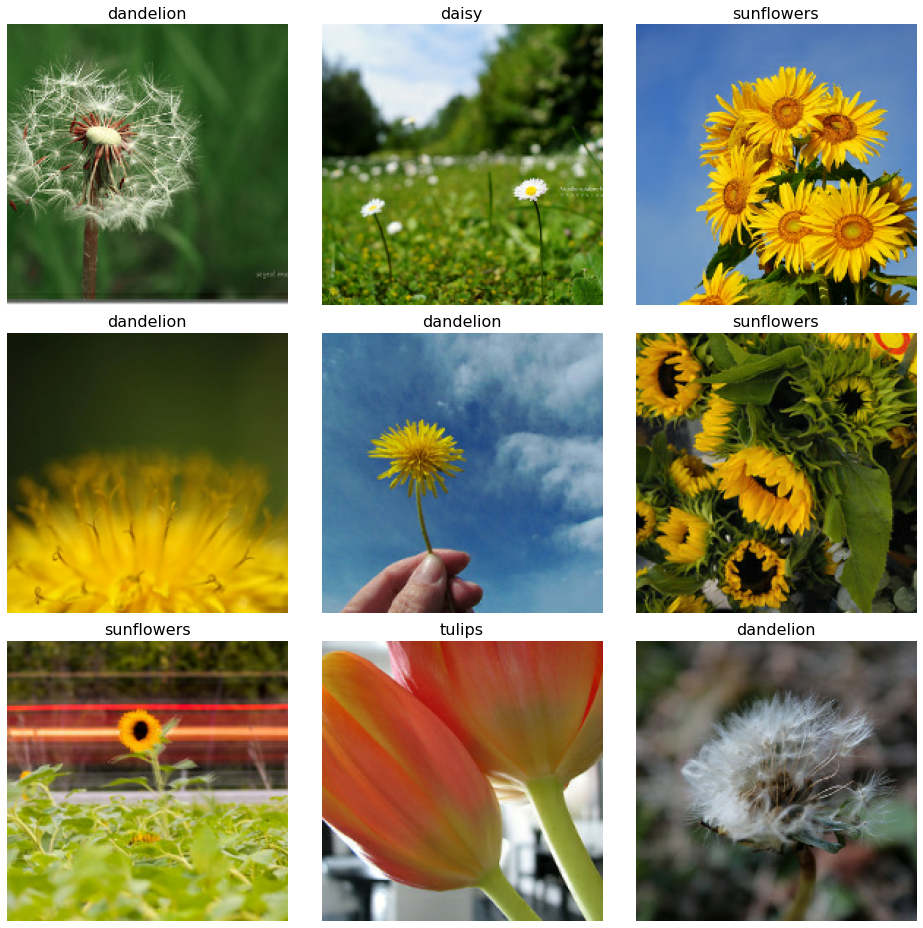

In [14]:
display_9_images_from_dataset(load_dataset(training_filenames))

### Create training and validation datasets

You will use the helper function `get_batched_dataset()` to create the training and validation datasets for training the model, with the properties:

- `cache()` - Loads the entire dataset into memory.
- `shuffle(2048)` - Randomly shuffles 2048 examples from the dataset at a time per epoch.
- `repeat()` - Allow repeat iterating thru the entire dataset. One iteration is an epoch.
- `batch(BATCH_SIZE)` - Sets the batch size.
- `prefetch(AUTO)` - Prefetch the next batch in parallel to feeding the current batch to the model duringg training.

In [15]:
def get_batched_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.cache()  # This dataset fits in RAM
    dataset = dataset.shuffle(2048)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)  # prefetch next batch while training (autotune prefetch buffer size)
    # For proper ordering of map/batch/repeat/prefetch, see Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets
    return dataset


def get_training_dataset():
    return get_batched_dataset(training_filenames)


def get_validation_dataset():
    return get_batched_dataset(validation_filenames)


Next, you will use the helper functions to get a subset of the validation images, which we will set aside to use later in the tutorial for the prediction and explanation.

In [16]:
some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 160)

## Build, train, and evaluate the model

This section shows how to build, train, evaluate, and get local predictions from a model by using the TF.Keras [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model).

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # Stem
    Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=[*IMAGE_SIZE, 3]),
    BatchNormalization(),
    Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),

    # Conv Group
    Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Conv2D(kernel_size=3, filters=96, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),

    # Conv Group
    Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    BatchNormalization(),

    # 1x1 Reduction
    Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),

    # Classifier
    GlobalAveragePooling2D(),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=Adam(lr=0.005, decay=0.98),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 192, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 64)        2

### Train the model

Train this on a GPU if you have access (in Colab, from the menu select **Runtime** --> **Change runtime type**). On a CPU, it'll take ~30 minutes to run training. On a GPU, it takes ~5 minutes.

In [ ]:
EPOCHS = 20  # Train for 60 epochs for higher accuracy, 20 should get you ~75%

history = model.fit(get_training_dataset(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=validation_steps)

Epoch 1/20
91/91 [==============================] - 179s 2s/step - loss: 1.3327 - accuracy: 0.4523 - val_loss: 1.7876 - val_accuracy: 0.2472
Epoch 2/20
91/91 [==============================] - 182s 2s/step - loss: 1.1820 - accuracy: 0.5422 - val_loss: 1.7092 - val_accuracy: 0.2685
Epoch 3/20
91/91 [==============================] - 191s 2s/step - loss: 1.1191 - accuracy: 0.5828 - val_loss: 1.5737 - val_accuracy: 0.2969
Epoch 4/20
91/91 [==============================] - 277s 3s/step - loss: 1.0931 - accuracy: 0.6030 - val_loss: 1.4145 - val_accuracy: 0.3423
Epoch 5/20
91/91 [==============================] - 182s 2s/step - loss: 1.0745 - accuracy: 0.6092 - val_loss: 1.2500 - val_accuracy: 0.4474
Epoch 6/20
91/91 [==============================] - 177s 2s/step - loss: 1.0616 - accuracy: 0.6243 - val_loss: 1.1129 - val_accuracy: 0.5710
Epoch 7/20
91/91 [==============================] - 179s 2s/step - loss: 1.0450 - accuracy: 0.6277 - val_loss: 1.0401 - val_accuracy: 0.6278
Epoch 8/20
91

### Visualize local predictions

Get predictions on your local model and visualize the images with their predicted labels, using the visualization utility function provided earlier. 

- `model.predict()`: You will use the subset of the validation data that you set aside to do predictions.
- `model.evaluate()`: For the same data, you will evaluate how accurate the model's predictions were.

In [ ]:
# Randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(160)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = model.predict(some_flowers, batch_size=16)
evaluations = model.evaluate(some_flowers, some_labels, batch_size=16)

print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

Next, you will visualize the result of the predictions for nine of the images.

In [ ]:
display_9_images_with_predictions(some_flowers, predictions, some_labels)

## Export the model as a TF 2.x SavedModel

When using TensorFlow 2.x, you export the model as a `SavedModel` and load it into Cloud Storage. During export, you need to define a serving function to convert data to the format your model expects. If you send encoded data to AI Platform, your serving function ensures that the data is decoded on the model server before it is passed as input to your model.

### Serving function for image data

Sending base 64 encoded image data to AI Platform makes the data safe from modification for transferring binary data over the Internet. Since this deployed model expects input data as raw bytes, you need to ensure that the b64 encoded data gets converted back to raw bytes before it is passed as input to the deployed model.

To resolve this, define a serving function (`serving_fn`) and attach it to the model as a preprocessing step. Add a `@tf.function` decorator so the serving function is part of the model's graph (instead of upstream on a CPU).

When you send a prediction or explanation request, the request goes to the serving function (`serving_fn`), which preprocesses the b64 bytes into raw numpy bytes (`preprocess_fn`). At this point, the data can be passed to the model (`m_call`).

Note, when you save the model with the serving function (`tf.saved_model.save()`), you need to specify some additional signatures:

- `serving_default`: This will override the model input entry point for a prediction to the serving function, which will decode the encoded image into raw bytes and shape expected by the model.

- `xai_preprocess`: This tells the XAI version of the model where the model preprocessing input entry point is for prediction, which the XAI model will use to generate explanations from a prediction that you can then visualize.

- `xai_model`: This tells the XAI version of the model where the model input entry point is for prediction, which is the input layer after the serving function.

In [ ]:
export_path = 'gs://' + BUCKET_NAME + '/explanations/mymodel'


def _preprocess(bytes_input):
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    resized = tf.image.resize(decoded, size=(192, 192))
    return resized


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    with tf.device("cpu:0"):
        decoded_images = tf.map_fn(_preprocess, bytes_inputs, dtype=tf.float32)
    return {"numpy_inputs": decoded_images}  # User needs to make sure the key matches model's input


m_call = tf.function(model.call).get_concrete_function([tf.TensorSpec(shape=[None, 192, 192, 3], dtype=tf.float32, name="numpy_inputs")])


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def serving_fn(bytes_inputs):
    images = preprocess_fn(bytes_inputs)
    prob = m_call(**images)
    return prob


tf.saved_model.save(model, export_path, signatures={
    'serving_default': serving_fn,
    'xai_preprocess': preprocess_fn,  # Required for XAI
    'xai_model': m_call  # Required for XAI
})

## Get input and output signatures

Use TensorFlow's `saved_model_cli` to inspect the model's SignatureDef. You'll use this information when you deploy your model to AI Explanations in the next section.

In [ ]:
! saved_model_cli show --dir $export_path --all

You can get the signatures of your model's input and output layers by reloading the model into memory, and querying it for the signatures corresponding to each layer.

You need the signatures for the following layers:

- Model input layer, after the serving function
- Model output layer
- Model image preprocessing layer

In [ ]:
loaded = tf.saved_model.load(export_path)

input_name = list(loaded.signatures['xai_model'].structured_input_signature[1].keys())[0]
print(input_name)

output_name = list(loaded.signatures['xai_model'].structured_outputs.keys())[0]
print(output_name)

preprocess_name = list(loaded.signatures['xai_preprocess'].structured_input_signature[1].keys())[0]
print(preprocess_name)

## Generate explanation metadata

In order to deploy this model to AI Explanations, you need to create an explanation_metadata.json file with information about your model inputs, outputs, and baseline. You can use the [Explainable AI SDK](https://pypi.org/project/explainable-ai-sdk/) to automatically generate the file and fill in most of the fields

You will start by instantiating a metadata builder object for a model in SavedModel format using `metadata.tf.v2.SavedModelMetadataBuilder`, with the parameters:

- `export_path`: The Cloud Storage location of the model.
- `signature_name`: Name of the signature to be explained. Inputs and outputs of this signature will be written in the metadata. If not provided, the default signature is used.

Next, you use the `set_image_metadata()` method to fill in the remaining fields:

- `input layer`: This tells Explanability which layer in the model is the input layer after the serving function, which in your case will be `numpy_inputs`.
- `input baselines`: For image models, using `[0,1]` as your input baseline represents black and white images. This example uses np.random to generate the baseline because the training images contain a lot of black and white (i.e. daisy petals).

Finally, you use the method `save_metadata()` to save the generated explanation_metadata.json file back to the same Cloud Storage location of the model.

*Note*: for the explanation request, use the model's signature for the input and output tensors. Do not use the serving function signature.

In [ ]:
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder

# We want to explain 'xai_model' signature.
builder = SavedModelMetadataBuilder(export_path, signature_name='xai_model')

random_baseline = np.random.rand(192, 192, 3)
builder.set_image_metadata(
    input_name,
    input_baselines=[random_baseline.tolist()])
builder.save_metadata(export_path)

## Deploy model to AI Platform Explanations

This section shows how to use `gcloud` to deploy the model to AI Platform Explanations, using two different explanation methods for image models.

### Create the model

In [ ]:
import datetime
MODEL = 'flowers' + TIMESTAMP
print(MODEL)

In [ ]:
# Create the model if it doesn't exist yet (you only need to run this once)
! gcloud ai-platform models create $MODEL --enable-logging --regions=us-central1

### Create explainable model versions

For image models, we offer two choices for explanation methods: 
* Integrated Gradients (IG)
* XRAI 

You can find more info on each method in the [documentation](TODO). You can deploy a version with both so that you can compare results. **If you already know which explanation method you'd like to use, you can deploy one version and skip the code blocks for the other method.**

Creating the version will take ~5-10 minutes. Note that your first deploy may take longer.

#### Deploy an Integrated Gradients model

Next, you will deploy an IG version of the model. You need to specify a name for the version, which is set by the variable `IG_VERSION`. Additionally, in the `gcloud` call, we add two additional command line arguments 

- `--explanation-method` : Specify which explanability method the model is to be instrumented for explanations --which in this case is for integrated gradients.
- `--num-integral-steps`: Specifies the number of integral steps to perform to approxiamate Shapley values. The more steps, the more exact the approxiamation will be. Defaults to 50.

In [ ]:
# Each time you create a version the name should be unique
IG_VERSION = 'v_ig'

In [ ]:
! gcloud beta ai-platform versions create $IG_VERSION \
--model $MODEL \
--origin $export_path \
--runtime-version 2.2 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method integrated-gradients \
--num-integral-steps 25

Now that your model is deployed, you can use `gcloud` to get information on its deployment, such as checking if the state is `READY`.

In [ ]:
# Make sure the IG model deployed correctly. State should be `READY` in the following log
! gcloud ai-platform versions describe $IG_VERSION --model $MODEL

#### Deploy an XRAI model

Next, you will deploy an XRAI version of the model. You need to specify a name for the version, which is set by the variable `XRAI_VERSION`. Additionally, in the `gcloud` call, we add two additional command line arguments 

- `--explanation-method` : Specify which explanability method the model is to be instrumented for explanations --which in this case is for XRAI.
- `--num-integral-steps`: Specifies the number of integral steps to perform to approxiamate Shapley values. The more steps, the more exact the approxiamation will be. Defaults to 50.

In [ ]:
# Each time you create a version the name should be unique
XRAI_VERSION = 'v_xrai'

In [ ]:
# Create the XRAI version with gcloud
! gcloud beta ai-platform versions create $XRAI_VERSION \
--model $MODEL \
--origin $export_path \
--runtime-version 2.2 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method xrai \
--num-integral-steps 25

Now that your model is deployed, you can use `gcloud` to get information on its deployment, such as checking if the state is `READY`.

In [ ]:
# Make sure the XRAI model deployed correctly. State should be `READY` in the following log
! gcloud ai-platform versions describe $XRAI_VERSION --model $MODEL

## Get predictions and explanations

This section shows how to prepare test images to send to your deployed model, and how to send a multi-instance prediction request to AI Explanations.

### Get and prepare test images

To prepare the test images:

- Download a small sample of images from the flowers dataset -- just enough for a batch prediction.
- Resize the images to match the input shape (192, 192) of the model.
- Save the resized images back to your bucket.

In [ ]:
# Download test flowers from public bucket
! mkdir flowers
! gsutil -m cp gs://flowers_model/test_flowers/* ./flowers

In [ ]:
# Resize the images to what your model is expecting (192,192)
test_filenames = []

for i in os.listdir('flowers'):
    img_path = 'flowers/' + i
    with PIL.Image.open(img_path) as ex_img:
        resize_img = ex_img.resize([192, 192])
        resize_img.save(img_path)
        test_filenames.append(img_path)

### Format your explanation request

Next, you will prepare a multi-instance request for the small sample of test files. You will create a list `instances = []`, with an entry for each sample test file. 

For each test file, you will read in the raw bytes from disk of the image on Cloud Storage using `tf.io.read_file()`. This will return a bytes string. Since the model takes its input as a numpy array, you will convert the bytes string to a numpy array. You then base 64 encode the data for transmission over the Internet using the method `b64encode()`. 

Next, we select the character encoding for the base 64 encoded string, which in this case it is set to UTF-8 using the method decode('utf-8').

Finally, we package the explanation request as a dictionary object, in the form:

    { '[input_layer_name]': { 'b64': [b64 encoded content content] }

In [ ]:
# Prepare your images to send to your Cloud model
instances = []

for image_path in test_filenames:
    img_bytes = tf.io.read_file(image_path)
    b64str = b64encode(img_bytes.numpy()).decode('utf-8')
    instances.append({preprocess_name: {'b64': b64str}})

### Send the explanations request and visualize

If you deployed both an IG and an XRAI model, you can request explanations for both models and compare the results.

**If you only deployed one model above, run only the cell for that explanation method.**

You can use the AI Platform Explainability SDK to send explanation requests to your deployed model and visualize the explanations. The method `load_model_from_ai_platform()` creates a client side interface, saved as `remote_ig_model` to the deployed model.

Using the client side interface, you can make an `explain()` call to the deployed model using the SDK.

In [ ]:
# IG EXPLANATIONS
remote_ig_model = explainable_ai_sdk.load_model_from_ai_platform(PROJECT_ID, MODEL, IG_VERSION)
ig_response = remote_ig_model.explain(instances)

The `explain()` method will return a list with an entry for each instance in the request. In this tutorial, you sent three images for prediction and explanation, and receive back a list of three entries, corresponding to the respective instance -- i.e., image to predict/explain.

Each entry contains a `model.explanation.Explanation` object for the instance. You can visualize the explanation for the prediction using this object's `visualize_attributions()` method, where:

- `Label Index`: The label predicted for the instance.
- `Example Score`: The percent confidence [0, 1] that the model had for the predicted label.
- `Baseline Score`: The baseline score that the example score was compared to.
- `Approximation Error`: The percent of error in approximating the exact Shapley values. Anything under 5% (0.05) is good. Otherwise, consider increasing the number of integral steps when you deploy the model to reduce the error.

This is then followed by a visualization of the image's pixel data, where the pixels are highlighted in shades of green to denote how much the pixel contributed to the prediction. The darker the green the more that pixel contributed to the prediction.

In [ ]:
for response in ig_response:
    response.visualize_attributions()

In [ ]:
# XRAI EXPLANATIONS
remote_xrai_model = explainable_ai_sdk.load_model_from_ai_platform(PROJECT_ID, MODEL, XRAI_VERSION)
xrai_response = remote_xrai_model.explain(instances)

In [ ]:
for response in xrai_response:
    response.visualize_attributions()

## Check explanations and baselines

To better make sense of your feature attributions, you can compare them with your model's baseline. For image models, the baseline_score returned by AI Explanations is the score your model would give an image input with the baseline you specified. The baseline is different for each class in the model. Every time your model predicts tulip as the top class, you'll see the same baseline score.

Earlier, you used a baseline image of np.random randomly generated values. If you'd like the baseline for your model to be solid black and white images instead, pass [0,1] as the value to input_baselines in your explanation_metadata.json file above. If the baseline_score is very close to the value of example_score, the highlighted pixels may not be meaningful.

Calculate the difference between baseline_score and example_score for the three test images above.

Note that the score values for classification models are probabilities: the confidence your model has in its predicted class. A score of 0.90 for tulip means your model has classified the image as a tulip with 90% confidence.

The code below checks baselines for the IG model. To inspect your XRAI model, swap out the ig_response and IG_VERSION variables below.

In [ ]:
for i, response in enumerate(ig_response):
    attr = response.get_attribution()
    baseline_score = attr.baseline_score
    predicted_score = attr.example_score
    print('Baseline score: ', baseline_score)
    print('Predicted score: ', predicted_score)
    print('Predicted - Baseline: ', predicted_score - baseline_score, '\n')

### Explain the baseline image

Another way to check your baseline choice is to view explanations for this model's baseline image: an image array of randomly generated values using np.random. First, convert the same np.random baseline array generated earlier to a base64 string and preview it. This encodes the random noise as if it's a PNG image. Additionally, you must convert the byte buffer to a numpy array, because this is the format the underlying model expects for input when you send the explain request.

In [ ]:
# Convert your baseline from above to a base64 string
rand_test_img = PIL.Image.fromarray((random_baseline * 255).astype('uint8'))
buffer = io.BytesIO()
rand_test_img.save(buffer, format="PNG")
new_image_string = b64encode(np.asarray(buffer.getvalue())).decode("utf-8")

# Preview it
plt.imshow(rand_test_img)

In [ ]:
sanity_check_img = {preprocess_name: {'b64': new_image_string}}

Send the explanation request for the baseline image. (To check a baseline image for XRAI, change IG_VERSION to XRAI_VERSION below.)

In [ ]:
# Sanity Check explanations EXPLANATIONS
sanity_check_response = remote_ig_model.explain([sanity_check_img])

Visualize the explanation for your random baseline image, highlighting the pixels that contributed to the prediction

In [ ]:
sanity_check_response[0].visualize_attributions()

The difference between your model's predicted score and the baseline score for this image should be close to 0. Run the following cell to confirm. If there is a difference between these two values, try increasing the number of integral steps used when you deploy your model.

In [ ]:
attr = sanity_check_response[0].get_attribution()
baseline_score = attr.baseline_score
example_score = attr.example_score

print(abs(baseline_score - example_score))

## Cleaning up

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Alternatively, you can clean up individual resources by running the following
commands:

In [ ]:
# Delete model version resource
! gcloud ai-platform versions delete $IG_VERSION --quiet --model $MODEL
! gcloud ai-platform versions delete $XRAI_VERSION --quiet --model $MODEL

# Delete model resource
! gcloud ai-platform models delete $MODEL --quiet

# Delete Cloud Storage objects that were created
! gsutil -m rm -r gs://$BUCKET_NAME

If your Cloud Storage bucket doesn't contain any other objects and you would like to delete it, run `gsutil rm -r gs://$BUCKET_NAME`.

## What's next?

To learn more about AI Explanations, check out the resources here.

* [AI Explanations documentation](https://cloud.google.com/ai-platform/prediction/docs/ai-explanations/overview)
* [AI Explanations whitepaper](https://storage.googleapis.com/cloud-ai-whitepapers/AI%20Explainability%20Whitepaper.pdf)
* [Integrated gradients paper](https://arxiv.org/abs/1703.01365)
* [XRAI paper](https://arxiv.org/abs/1906.02825)